# Chest X-ray Classification and Localization using DenseNet

This notebook implements a transfer learning approach using DenseNet for chest X-ray classification and localization on the NIH Chest X-ray dataset.

In [1]:
!pip install torch torchvision pandas numpy matplotlib tqdm scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 23.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 46.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 261.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 216.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 212.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 27.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 25.8

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import models
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data Curation

In [152]:
# Define paths
BASE_PATH = 'DL_for_HIN_Chest_X_Ray'
IMAGES_PATH = os.path.join(BASE_PATH, 'archive','images', 'images')
CSV_PATH = os.path.join(BASE_PATH, 'Data_Entry_2017_filtered_2.csv')
BBOX_PATH = os.path.join(BASE_PATH,'archive', 'BBox_List_2017.csv')

# Load the filtered dataset
df = pd.read_csv(CSV_PATH)
df.rename(columns={'Finding Labels': 'Finding Label'}, inplace=True)
df.drop(columns=['Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width','Height]', 'OriginalImagePixelSpacing[x', 'y]'], inplace=True)
no_finding_images = df[df['Finding Label'] == 'No Finding'].head(2016)


bbox_df = pd.read_csv(BBOX_PATH)
bbox_df.drop(columns=['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'], inplace=True)
bbox_df.columns = ['Image Index','Finding Label', 'x', 'y', 'width', 'height']

combined_df = pd.concat([no_finding_images, bbox_df])

combined_df.shape
combined_df['Image Index'].value_counts()

combined_df[combined_df['Image Index'] == '00010277_000.png']

Image Index Finding Label           x           y       width  \
326  00010277_000.png      Effusion  863.004444  693.229045   72.817778   
474  00010277_000.png    Infiltrate  633.173333  416.749045  271.928889   
590  00010277_000.png          Mass  297.528889  310.935712  540.444444   
752  00010277_000.png     Pneumonia  642.275556  423.575712  265.102222   

         height  
326  112.640000  
474  221.866667  
590  277.617778  
752  223.004444

In [144]:
import os
from PIL import Image

# Define the new directory to save resized images
resized_images_dir = 'resized_images'
os.makedirs(resized_images_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Strip whitespace from image filenames
combined_df['Image Index'] = combined_df['Image Index'].str.strip()

# Iterate over all images_[XXX] folders in the archive directory
archive_path = os.path.join('DL_for_HIN_Chest_X_Ray', 'archive')  # Adjust this path as needed

# Resize and save images
for index, row in combined_df.iterrows():
    image_name = row['Image Index']
    found = False  # Flag to check if the image was found

    # Walk through the archive directory
    for root, dirs, files in os.walk(archive_path):
        if image_name in files:
            image_path = os.path.join(root, image_name)  # Construct the full image path
            print(f"Found image: {image_path}")  # Debugging line
            found = True
            try:
                # Open the image
                with Image.open(image_path) as img:
                    # Resize the image
                    img_resized = img.resize((224, 224))
                    # Save the resized image to the new directory
                    img_resized.save(os.path.join(resized_images_dir, image_name))
                    print(f"Saved resized image: {image_name}")  # Debugging line
            except OSError as e:
                print(f"Error processing {image_name}: {e}")
            except Exception as e:
                print(f"Unexpected error with {image_name}: {e}")
            break  # Exit the loop once the image is found

    if not found:
        print(f"File does not exist in any subdirectory: {image_name}")
    print(index)

Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000002_000.png
Saved resized image: 00000002_000.png
1
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000005_000.png
Saved resized image: 00000005_000.png
3
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000005_001.png
Saved resized image: 00000005_001.png
4
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000005_002.png
Saved resized image: 00000005_002.png
5
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000005_003.png
Saved resized image: 00000005_003.png
6
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000005_004.png
Saved resized image: 00000005_004.png
7
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000005_005.png
Saved resized image: 00000005_005.png
8
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000006_000.png
Saved resized image: 00000006_000.png
10
Found image: DL_for_HIN_Chest_X_Ray/archive/ima

KeyboardInterrupt: 

In [153]:
combined_df.to_csv('bbox_resized_filtered_images.csv', index=False)

## Data Loading and Preprocessing

In [5]:
IMAGES_PATH_RESIZED = os.path.join('resized_images')
PREPROCESSED_IMAGES_PATH = os.path.join('bbox_resized_filtered_images.csv')
df_preprocessed = pd.read_csv(PREPROCESSED_IMAGES_PATH)

In [6]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ChestXrayDataset(Dataset):
    def __init__(self, image_dir, df, transform=None):
        self.image_dir = image_dir
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['Image Index']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        # Get labels (binary classification: normal vs abnormal)
        label = 1 if self.df.iloc[idx]['Finding Label'] != 'No Finding' else 0
        return image, torch.tensor(label, dtype=torch.float32)

Using device: cuda


In [ ]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should return > 0
print(torch.cuda.get_device_name(0))  # Should return the name of the GPU

True
1
NVIDIA A40


In [8]:
def get_transforms():
    """Define image transformations."""
    return {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

g = torch.Generator()
g.manual_seed(42)

# Split data and create data loaders
train_df, temp_df = train_test_split(df_preprocessed, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Get transforms
transforms_dict = get_transforms()

# Create datasets
train_dataset = ChestXrayDataset(IMAGES_PATH_RESIZED, train_df, transform=transforms_dict['train'])
val_dataset = ChestXrayDataset(IMAGES_PATH_RESIZED, val_df, transform=transforms_dict['val'])
test_dataset = ChestXrayDataset(IMAGES_PATH_RESIZED, test_df, transform=transforms_dict['val'])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 2400
Validation samples: 300
Test samples: 300


## Model Training

In [9]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attn_map = self.sigmoid(self.conv(x))  # Generate attention map
        return x * attn_map, attn_map

class DenseNetWithAttention(nn.Module):
    def __init__(self, num_classes=1):
        super(DenseNetWithAttention, self).__init__()
        # Load pre-trained DenseNet
        densenet = models.densenet121(pretrained=True)
        # Get features (everything except classifier)
        self.features = densenet.features
        
        # Create attention mechanism
        self.attention = SpatialAttention(1024)  # DenseNet121 outputs 1024 channels
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        # First run feature extraction
        x = self.features(x)
        # Then apply attention to features
        x, attn_map = self.attention(x)
        # Pool and classify
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        
        return logits, attn_map

# Create model
model = DenseNetWithAttention().to(device)

/root/XAI_medical_deeplearning/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/XAI_medical_deeplearning/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 461MB/s]


In [10]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    """Train the model."""
    criterion = nn.BCELoss()
    # Use parameters from all parts of the model, not just classifier
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            # Handle the attention model which returns (outputs, attn_map)
            outputs, _ = model(images)  # Ignore attention map during training
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                # Handle the attention model which returns (outputs, attn_map)
                outputs, _ = model(images)  # Ignore attention map during validation
                loss = criterion(outputs.squeeze(), labels)
                
                val_loss += loss.item()
                predicted = (outputs.squeeze() > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        
        gap = abs(train_accuracy - val_accuracy)
        # Save best model
        if avg_val_loss < best_val_loss and gap <= 5:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_densenet_attention_model.pth')
            print(f'Model saved! Val Acc: {train_accuracy:.2f}%, Train Acc: {val_accuracy:.2f}%, Gap: {gap:.2f}%')
        
        print('-' * 60)
    
    return train_losses, val_losses

In [36]:
# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=10)


Epoch 1/10: 100%|██████████| 75/75 [00:08<00:00,  9.12it/s]


Epoch 1/10:
Training Loss: 0.5230, Training Accuracy: 74.29%
Validation Loss: 1.2249, Validation Accuracy: 40.33%
------------------------------------------------------------


Epoch 2/10: 100%|██████████| 75/75 [00:08<00:00,  8.77it/s]


Epoch 2/10:
Training Loss: 0.4981, Training Accuracy: 76.96%
Validation Loss: 0.4671, Validation Accuracy: 76.00%
Model saved! Val Acc: 76.96%, Train Acc: 76.00%, Gap: 0.96%
------------------------------------------------------------


Epoch 3/10: 100%|██████████| 75/75 [00:08<00:00,  9.28it/s]


Epoch 3/10:
Training Loss: 0.4598, Training Accuracy: 78.71%
Validation Loss: 0.5437, Validation Accuracy: 75.33%
------------------------------------------------------------


Epoch 4/10: 100%|██████████| 75/75 [00:08<00:00,  8.70it/s]


Epoch 4/10:
Training Loss: 0.4479, Training Accuracy: 79.42%
Validation Loss: 0.4468, Validation Accuracy: 77.33%
Model saved! Val Acc: 79.42%, Train Acc: 77.33%, Gap: 2.08%
------------------------------------------------------------


Epoch 5/10: 100%|██████████| 75/75 [00:08<00:00,  9.23it/s]


Epoch 5/10:
Training Loss: 0.4443, Training Accuracy: 79.62%
Validation Loss: 0.4363, Validation Accuracy: 79.67%
Model saved! Val Acc: 79.62%, Train Acc: 79.67%, Gap: 0.04%
------------------------------------------------------------


Epoch 6/10: 100%|██████████| 75/75 [00:08<00:00,  9.36it/s]


Epoch 6/10:
Training Loss: 0.4254, Training Accuracy: 81.33%
Validation Loss: 0.4342, Validation Accuracy: 80.00%
Model saved! Val Acc: 81.33%, Train Acc: 80.00%, Gap: 1.33%
------------------------------------------------------------


Epoch 7/10: 100%|██████████| 75/75 [00:08<00:00,  9.34it/s]


Epoch 7/10:
Training Loss: 0.3992, Training Accuracy: 82.21%
Validation Loss: 0.5209, Validation Accuracy: 76.33%
------------------------------------------------------------


Epoch 8/10: 100%|██████████| 75/75 [00:07<00:00,  9.44it/s]


Epoch 8/10:
Training Loss: 0.4184, Training Accuracy: 80.46%
Validation Loss: 0.4813, Validation Accuracy: 77.33%
------------------------------------------------------------


Epoch 9/10: 100%|██████████| 75/75 [00:08<00:00,  9.27it/s]


Epoch 9/10:
Training Loss: 0.3965, Training Accuracy: 83.25%
Validation Loss: 0.4645, Validation Accuracy: 77.00%
------------------------------------------------------------


Epoch 10/10: 100%|██████████| 75/75 [00:08<00:00,  8.59it/s]


Epoch 10/10:
Training Loss: 0.3772, Training Accuracy: 83.88%
Validation Loss: 0.4271, Validation Accuracy: 82.00%
Model saved! Val Acc: 83.88%, Train Acc: 82.00%, Gap: 1.88%
------------------------------------------------------------


In [50]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score

def evaluate_attention_with_bbox(model, test_loader, df_preprocessed, image_size=(224, 224)):
    """
    Evaluate attention maps against ground truth bounding boxes
    
    Args:
        model: Your DenseNetWithAttention model
        test_loader: DataLoader containing test images
        df_preprocessed: DataFrame with bounding box information
        image_size: Size of images in the model
    """
    device = next(model.parameters()).device
    model.eval()
    
    results = {
        'iou_scores': [],
        'dice_scores': [],
        'precision_scores': [],
        'recall_scores': [],
        'ap_scores': [],
        'image_ids': [],
        'visualizations': []
    }
    
    with torch.no_grad():
        for images, labels, indices in test_loader:  # Modify your loader to include indices
            images = images.to(device)
            
            # Get predictions and attention maps
            _, attention_maps = model(images)
            
            # Process each image in batch
            for i, idx in enumerate(indices):
                # Convert idx to int if it's a tensor
                if torch.is_tensor(idx):
                    idx = idx.item()  # Convert tensor to Python int
                
                img_id = test_loader.dataset.df.iloc[idx]['Image Index']
                
                # Skip normal images (no bounding box)
                if test_loader.dataset.df.iloc[idx]['Finding Label'] == 'No Finding':
                    continue
                
                # Get bounding box for this image
                bbox_rows = df_preprocessed[df_preprocessed['Image Index'] == img_id]
                
                if len(bbox_rows) == 0:
                    continue  # Skip if no bounding box found
                
                # Rest of function remains the same...
                # Get attention map for this image
                attn_map = attention_maps[i].squeeze().cpu()
                
                # Create ground truth mask from all bounding boxes for this image
                gt_mask = torch.zeros(image_size)
                
                for _, bbox_row in bbox_rows.iterrows():
                    # Scale bbox coordinates to match attention map size
                    x = int(bbox_row['x'] * image_size[1] / 1024)
                    y = int(bbox_row['y'] * image_size[0] / 1024)
                    w = int(bbox_row['width'] * image_size[1] / 1024)
                    h = int(bbox_row['height'] * image_size[0] / 1024)
                    
                    # Ensure coordinates are within bounds
                    x, y = max(0, x), max(0, y)
                    w = min(w, image_size[1] - x)
                    h = min(h, image_size[0] - y)
                    
                    # Fill the bounding box area in the mask
                    if w > 0 and h > 0:
                        gt_mask[y:y+h, x:x+w] = 1.0
                
                # Continue with the rest of your evaluation code...
                # Resize attention map to match image size for comparison
                attn_map = F.interpolate(
                    attn_map.unsqueeze(0).unsqueeze(0),
                    size=image_size,
                    mode='bilinear'
                ).squeeze()
                
                # Normalize attention map to [0, 1]
                attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)
                
                # Calculate metrics
                # 1. IoU at different thresholds
                thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
                iou_at_thresholds = []
                
                for threshold in thresholds:
                    binary_attn = (attn_map > threshold).float()
                    intersection = (binary_attn * gt_mask).sum()
                    union = binary_attn.sum() + gt_mask.sum() - intersection
                    iou = (intersection / (union + 1e-8)).item()
                    iou_at_thresholds.append(iou)
                
                best_iou = max(iou_at_thresholds)
                results['iou_scores'].append(best_iou)
                
                # 2. Dice Coefficient
                threshold = thresholds[np.argmax(iou_at_thresholds)]
                binary_attn = (attn_map > threshold).float()
                intersection = (binary_attn * gt_mask).sum()
                dice = (2 * intersection) / (binary_attn.sum() + gt_mask.sum() + 1e-8)
                results['dice_scores'].append(dice.item())
                
                # 3. Precision-Recall curve and AP
                precision, recall, _ = precision_recall_curve(
                    gt_mask.flatten().numpy(), 
                    attn_map.flatten().numpy()
                )
                ap = average_precision_score(gt_mask.flatten().numpy(), attn_map.flatten().numpy())
                
                results['precision_scores'].append(precision)
                results['recall_scores'].append(recall)
                results['ap_scores'].append(ap)
                results['image_ids'].append(img_id)
                
                # Save visualization for the first few images
                if len(results['visualizations']) < 10:
                    original_img = images[i].cpu().permute(1, 2, 0).numpy()
                    # De-normalize the image
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    original_img = std * original_img + mean
                    original_img = np.clip(original_img, 0, 1)
                    
                    results['visualizations'].append({
                        'image': original_img,
                        'attention': attn_map.numpy(),
                        'ground_truth': gt_mask.numpy(),
                        'image_id': img_id
                    })
    
    # Calculate aggregate metrics
    mean_iou = np.mean(results['iou_scores'])
    mean_dice = np.mean(results['dice_scores'])
    mean_ap = np.mean(results['ap_scores'])
    
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Dice: {mean_dice:.4f}")
    print(f"Mean AP: {mean_ap:.4f}")
    
    return results

def visualize_attention_evaluation(results):
    """
    Visualize attention maps versus ground truth bounding boxes
    """
    n_samples = min(5, len(results['visualizations']))
    
    for i in range(n_samples):
        vis = results['visualizations'][i]
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image
        axes[0].imshow(vis['image'])
        axes[0].set_title(f"Image: {vis['image_id']}")
        axes[0].axis('off')
        
        # Attention map
        axes[1].imshow(vis['attention'], cmap='jet')
        axes[1].set_title(f"Attention Map\nIoU: {results['iou_scores'][i]:.4f}")
        axes[1].axis('off')
        
        # Ground truth
        axes[2].imshow(vis['ground_truth'], cmap='gray')
        axes[2].set_title("Ground Truth")
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()

# Modify your DataLoader to include indices
class ChestXrayDatasetWithIndices(Dataset):
    def __init__(self, image_dir, df, transform=None):
        self.image_dir = image_dir
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['Image Index']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        # Get labels (binary classification: normal vs abnormal)
        label = 1 if self.df.iloc[idx]['Finding Label'] != 'No Finding' else 0
        return image, torch.tensor(label, dtype=torch.float32), idx

/root/XAI_medical_deeplearning/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/XAI_medical_deeplearning/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mean IoU: 0.1003
Mean Dice: 0.1680
Mean AP: 0.1354


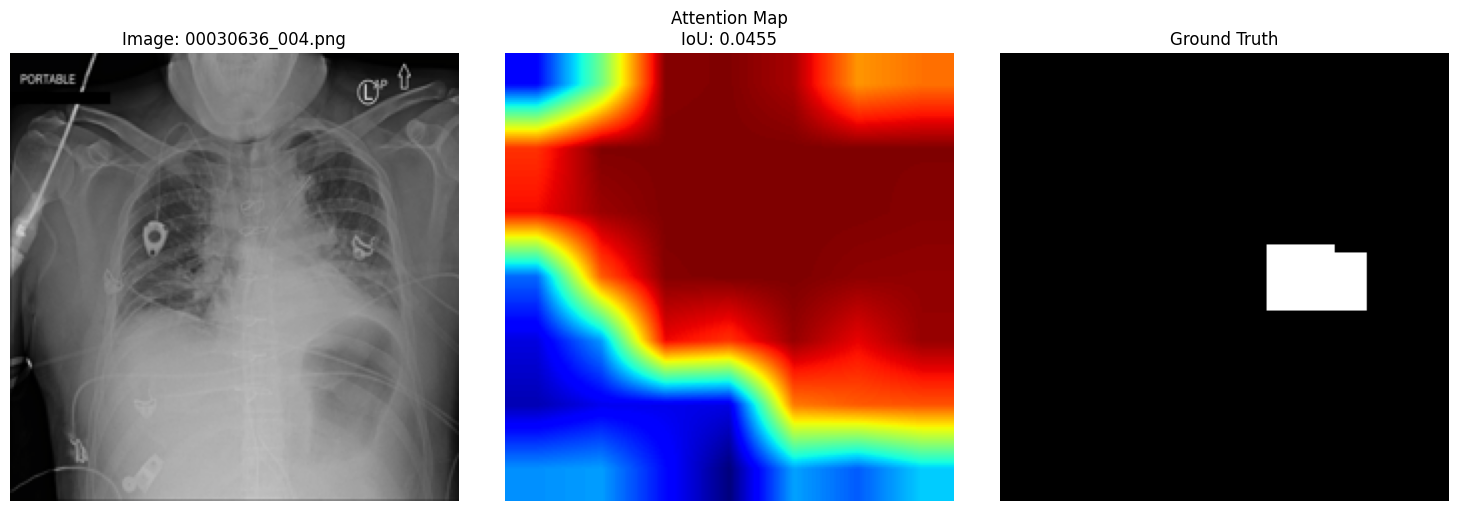

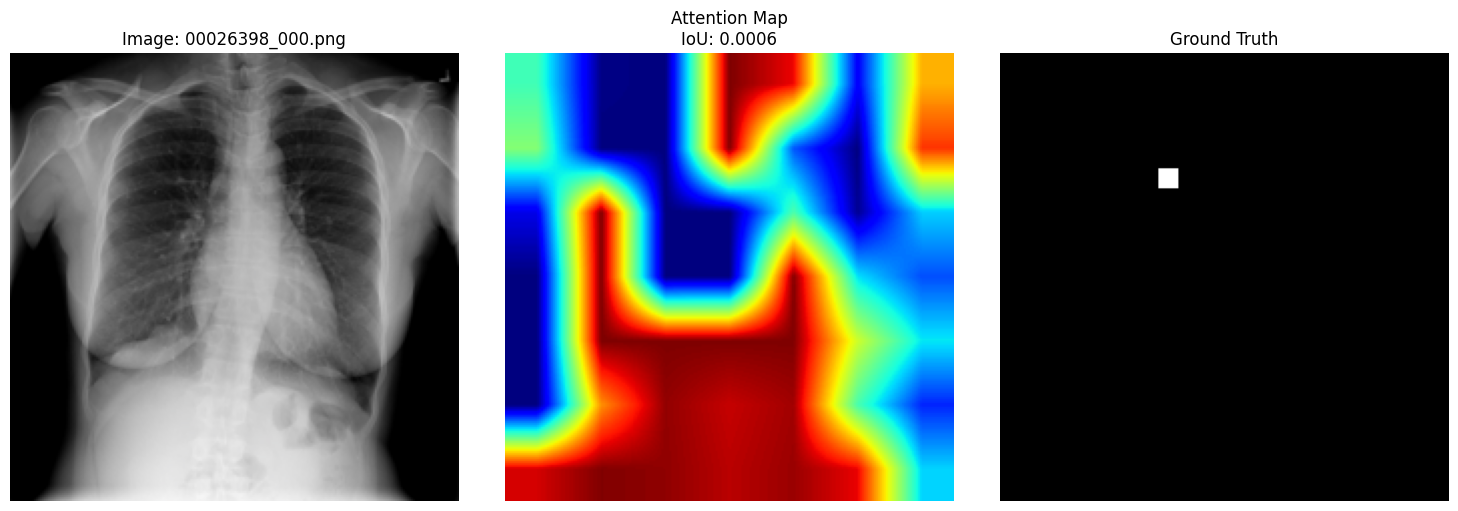

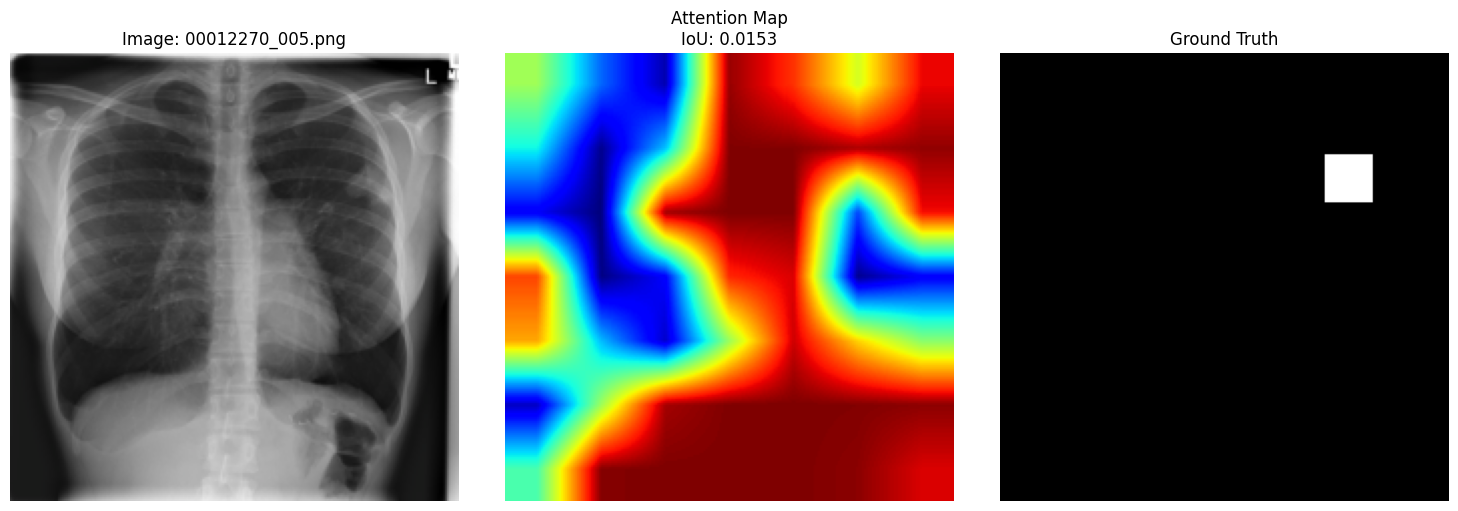

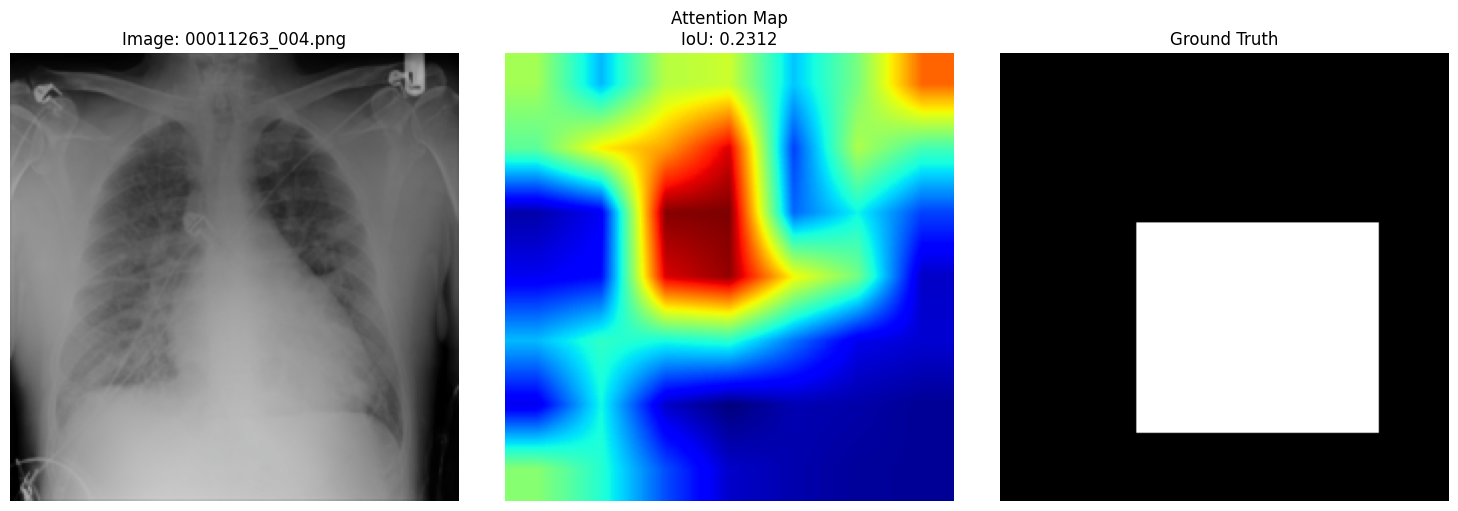

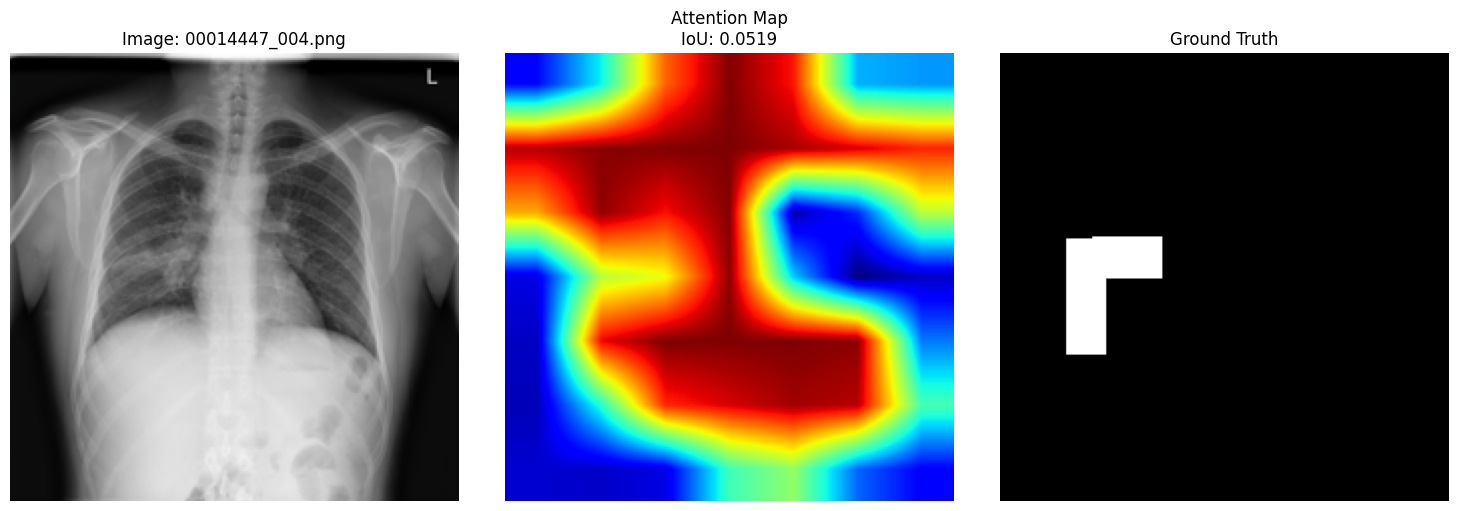

In [52]:
# First, make sure your dataset class is returning indices properly
class ChestXrayDatasetWithIndices(Dataset):
    def __init__(self, image_dir, df, transform=None):
        self.image_dir = image_dir
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['Image Index']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        # Get labels
        label = 1 if self.df.iloc[idx]['Finding Label'] != 'No Finding' else 0
        return image, torch.tensor(label, dtype=torch.float32), idx  # Return idx as an integer

# Create test dataset with indices
test_dataset = ChestXrayDatasetWithIndices(IMAGES_PATH_RESIZED, test_df, transform=transforms_dict['val'])
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)


# 2. Load your model
model = DenseNetWithAttention().to(device)
model.load_state_dict(torch.load('best_densenet_attention_model.pth'))

# 3. Evaluate attention maps
results = evaluate_attention_with_bbox(model, test_loader, df_preprocessed)

# 4. Visualize results
visualize_attention_evaluation(results)

Image ID: 00030636_004.png, Finding: ['Infiltrate' 'Atelectasis']


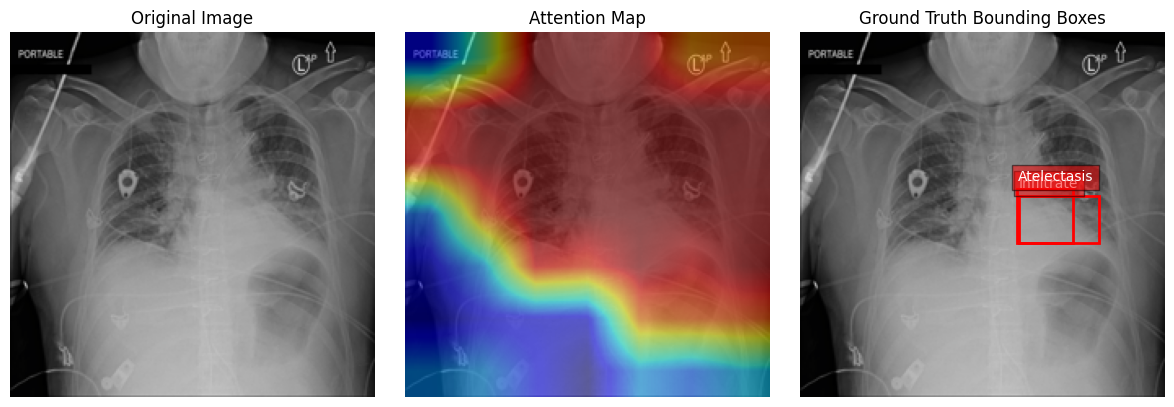

Image ID: 00026398_000.png, Finding: ['Nodule']


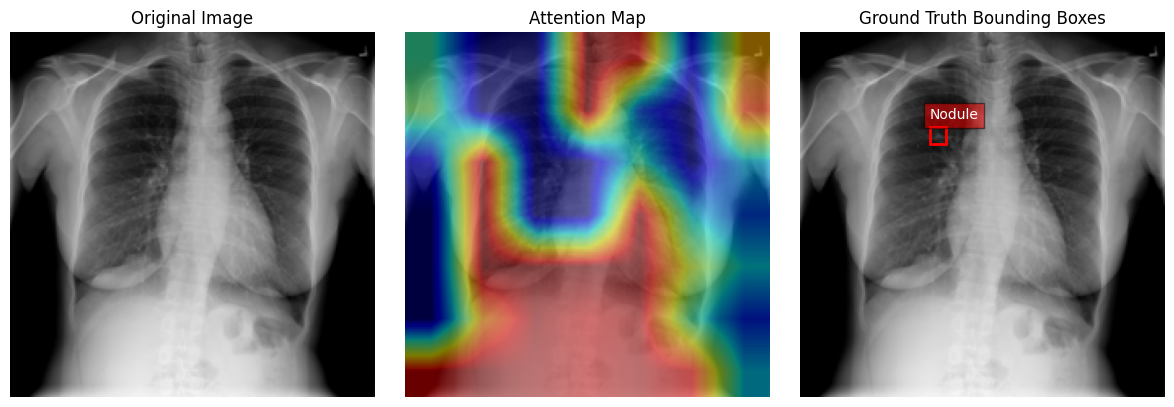

Image ID: 00012270_005.png, Finding: ['Mass']


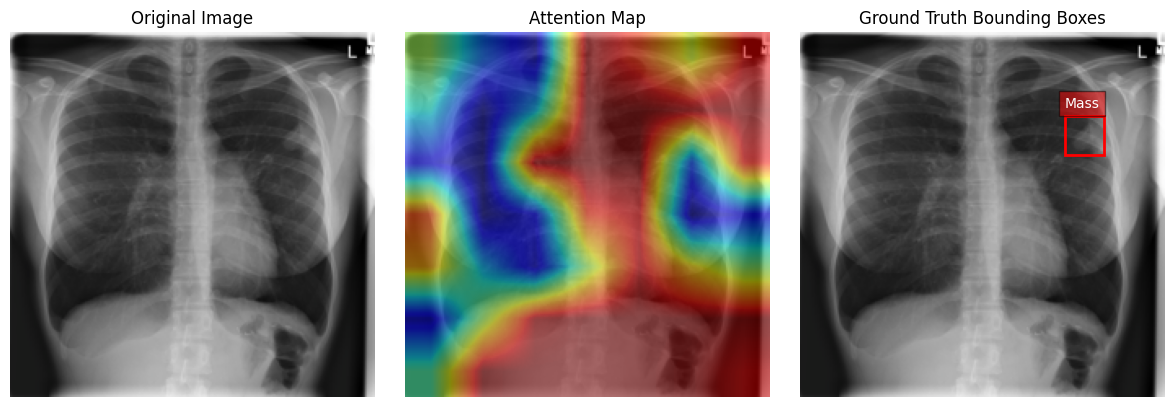

Image ID: 00011263_004.png, Finding: ['Cardiomegaly']


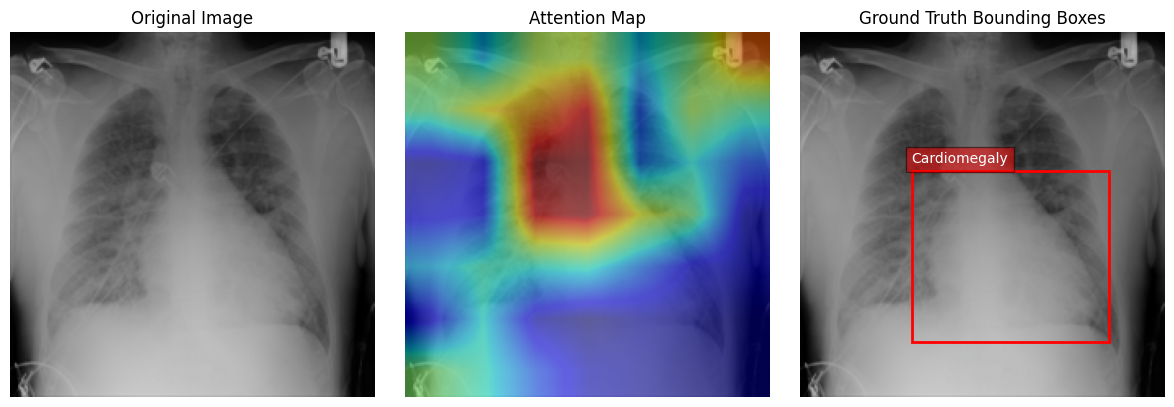

Image ID: 00014447_004.png, Finding: ['Atelectasis' 'Effusion']


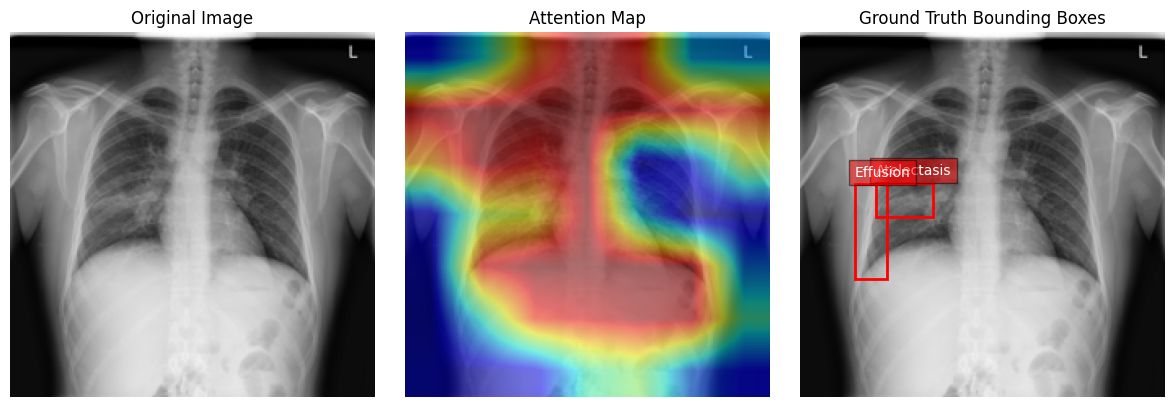

In [56]:
def visualize_samples_with_overlay(model, test_loader, df_preprocessed, num_samples=5):
    """
    Visualize sample images with overlaid attention maps and bounding boxes
    
    Args:
        model: Your DenseNetWithAttention model
        test_loader: DataLoader containing test images
        df_preprocessed: DataFrame with bounding box information
        num_samples: Number of samples to visualize
    """
    device = next(model.parameters()).device
    model.eval()
    
    samples_visualized = 0
    
    with torch.no_grad():
        for images, labels, indices in test_loader:
            images = images.to(device)
            
            # Get model predictions with attention maps
            _, attention_maps = model(images)
            
            # Process each image in the batch
            for i, idx in enumerate(indices):
                # Convert idx to int if it's a tensor
                if torch.is_tensor(idx):
                    idx = idx.item()  # Convert tensor to Python int
                
                img_id = test_loader.dataset.df.iloc[idx]['Image Index']
                
                # Skip normal images (no bounding box)
                if test_loader.dataset.df.iloc[idx]['Finding Label'] == 'No Finding':
                    continue
                
                # Get bounding box data for this image
                bbox_data = df_preprocessed[df_preprocessed['Image Index'] == img_id]
                
                if len(bbox_data) == 0:
                    continue  # Skip if no bounding box found
                
                # Get the attention map and convert to numpy
                attn_map = attention_maps[i].squeeze().cpu()
                
                # Resize attention map to match image size
                attn_map = F.interpolate(
                    attn_map.unsqueeze(0).unsqueeze(0),
                    size=(224, 224),  # Match your image size
                    mode='bilinear'
                ).squeeze().numpy()
                
                # Normalize attention map to [0, 1]
                attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)
                
                # Convert image to numpy and de-normalize
                img_np = images[i].cpu().permute(1, 2, 0).numpy()
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img_np = std * img_np + mean
                img_np = np.clip(img_np, 0, 1)
                
                # Call the overlay function
                print(f"Image ID: {img_id}, Finding: {bbox_data['Finding Label'].values}")
                overlay_attention_and_bbox(img_np, attn_map, bbox_data)
                
                samples_visualized += 1
                if samples_visualized >= num_samples:
                    return

# Usage:
# First make sure you have the model loaded
model = DenseNetWithAttention().to(device)
model.load_state_dict(torch.load('best_densenet_attention_model.pth'))

# Create test dataset with indices
test_dataset = ChestXrayDatasetWithIndices(IMAGES_PATH_RESIZED, test_df, transform=transforms_dict['val'])
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Call the visualization function
visualize_samples_with_overlay(model, test_loader, df_preprocessed, num_samples=5)

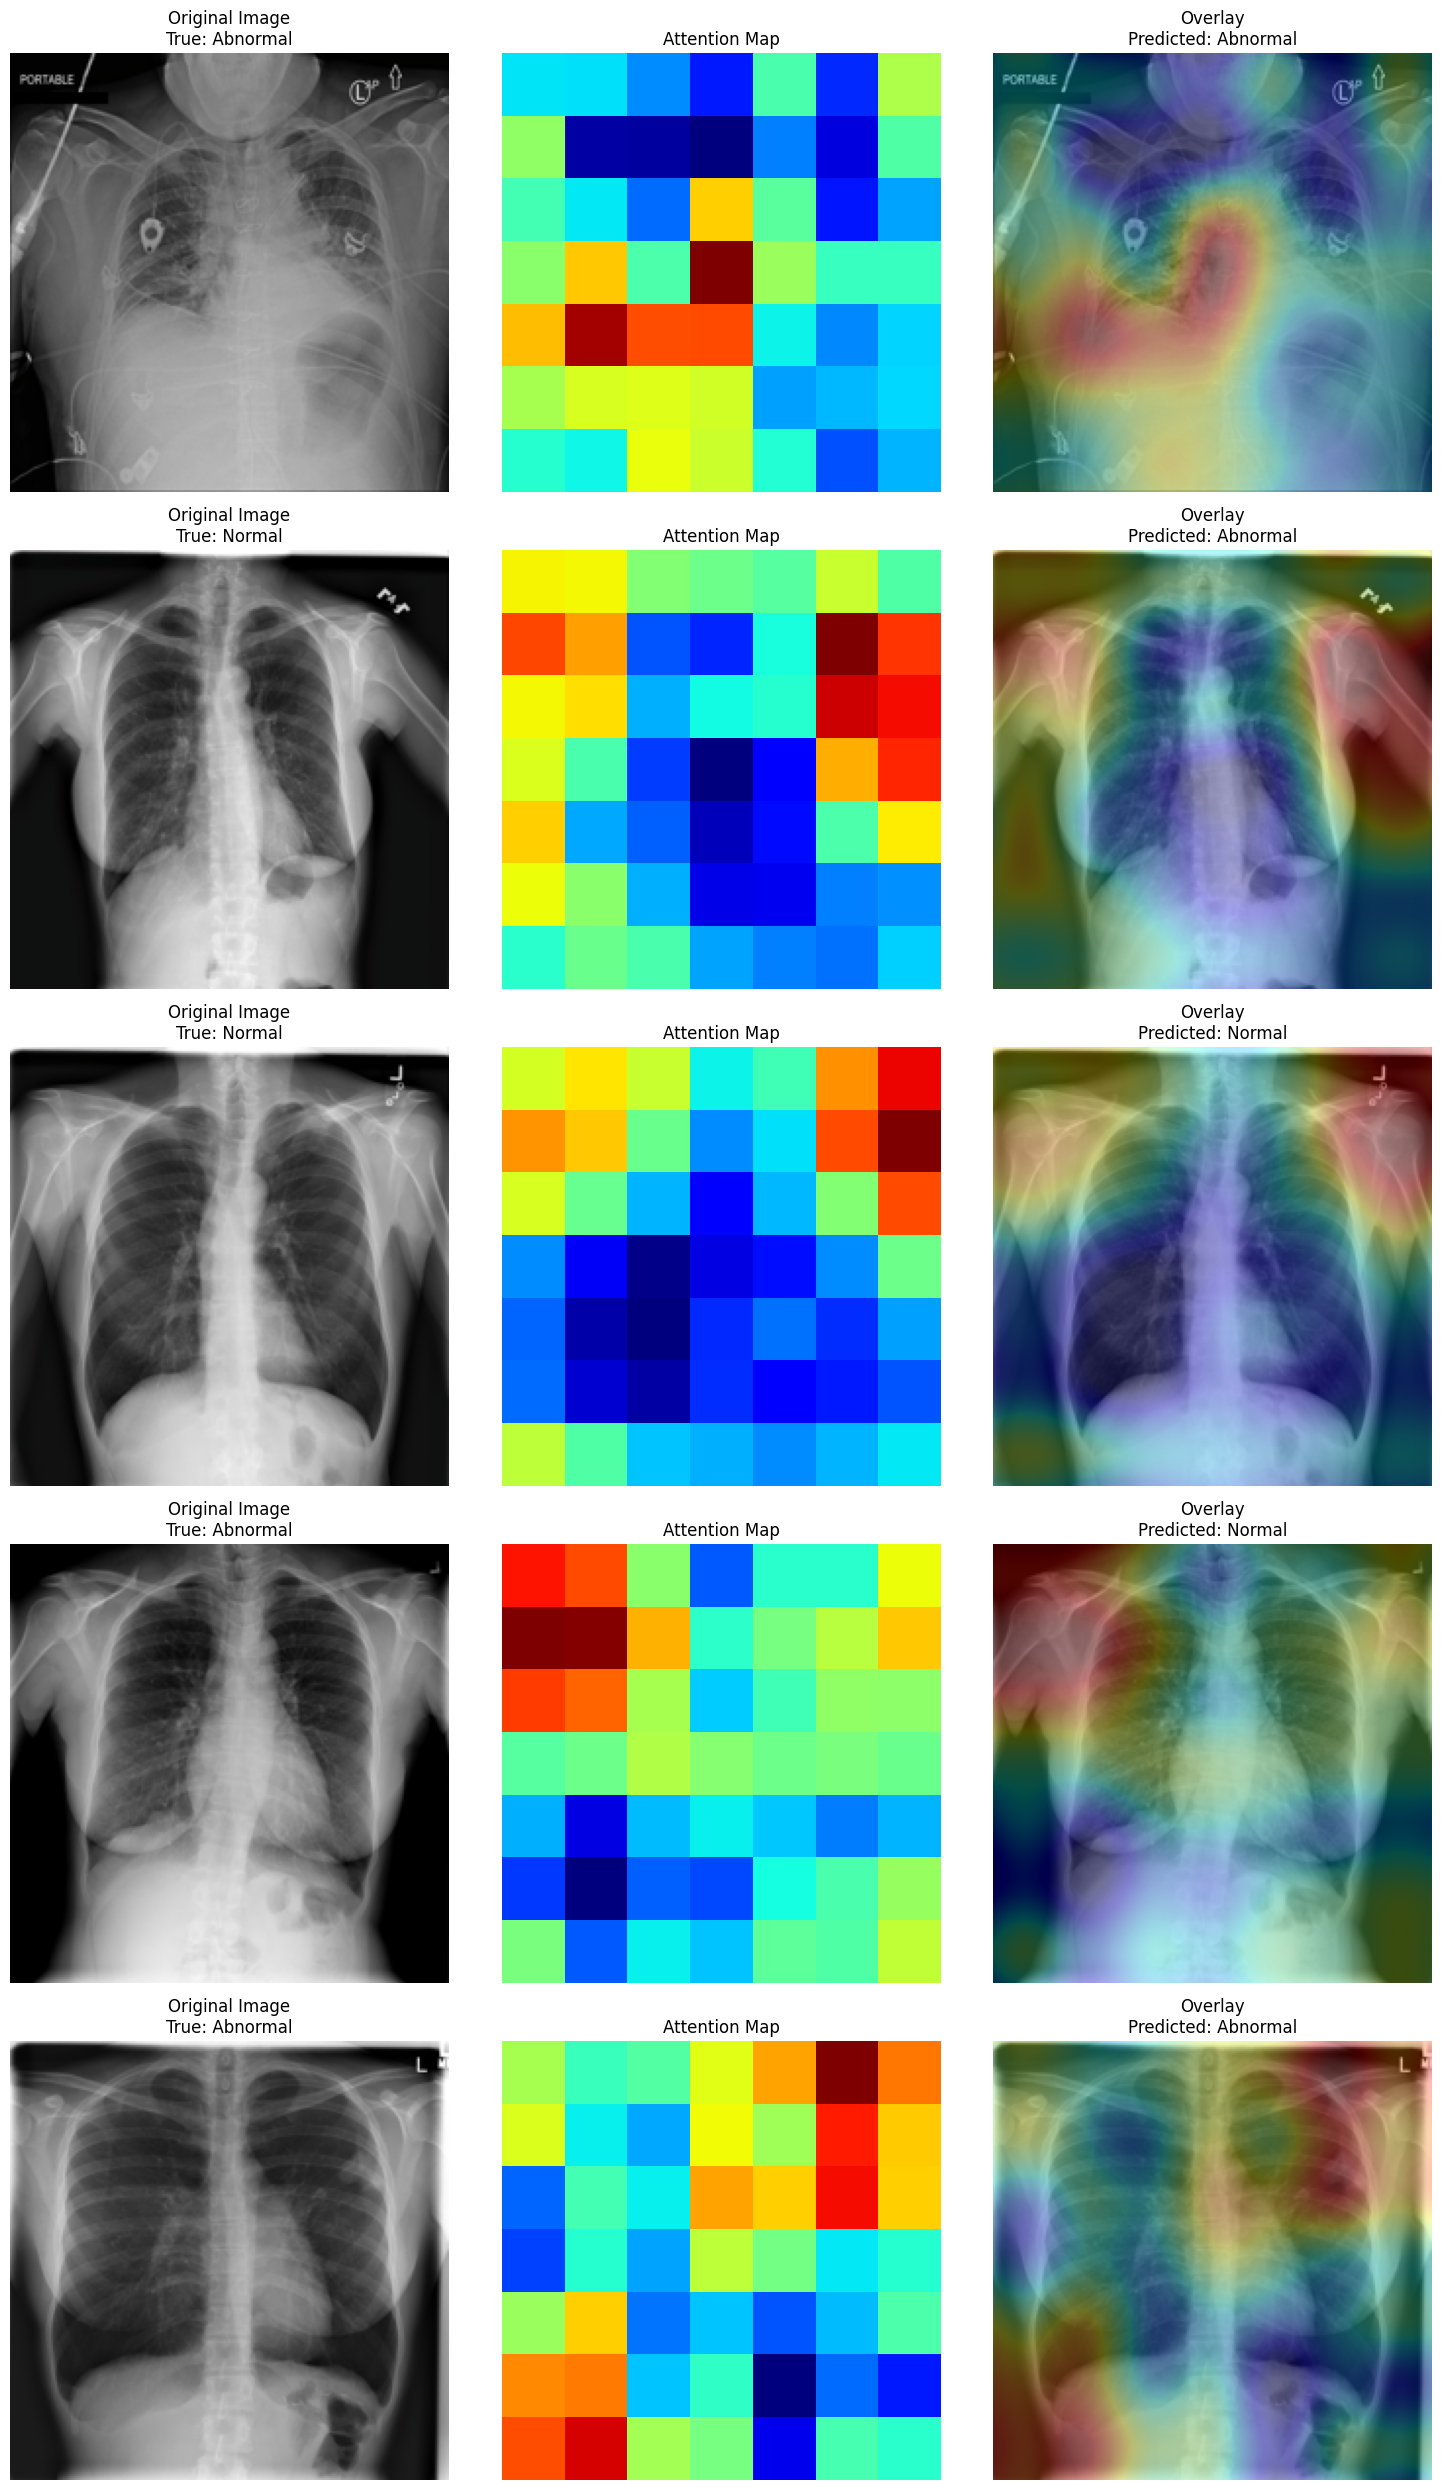

In [41]:
import skimage
def visualize_attention_maps(model, dataloader, num_images=3):
    """
    Visualize attention maps for a few images from the dataset.
    
    Args:
        model: The trained attention model
        dataloader: DataLoader containing the images
        num_images: Number of images to visualize
    """
    # Set model to eval mode
    model.eval()
    
    # Get a batch of images
    images, labels = next(iter(dataloader))
    
    # Limit to specified number of images
    images = images[:num_images]
    labels = labels[:num_images]
    
    # Move to device
    images = images.to(device)
    
    # Get predictions and attention maps
    with torch.no_grad():
        outputs, attention_maps = model(images)
        predictions = (outputs.squeeze() > 0.5).float()
    
    # Convert tensors to numpy for visualization
    images_np = images.cpu().numpy()
    attention_maps_np = attention_maps.cpu().numpy()
    
    # Plot results
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5*num_images))
    
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    class_labels = ['Normal', 'Abnormal']
    
    for i in range(num_images):
        # Original image
        img = np.transpose(images_np[i], (1, 2, 0))
        img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Original Image\nTrue: {class_labels[int(labels[i])]}')
        axes[i, 0].axis('off')
        
        # Attention map
        attn_map = attention_maps_np[i, 0]  # Shape: [H, W]
        axes[i, 1].imshow(attn_map, cmap='jet')
        axes[i, 1].set_title('Attention Map')
        axes[i, 1].axis('off')
        
        # Overlay attention on image
        # Resize attention map to match image size
        from skimage.transform import resize
        attn_map_resized = resize(attn_map, (img.shape[0], img.shape[1]), order=3)
        
        # Normalize attention map
        attn_map_resized = (attn_map_resized - attn_map_resized.min()) / (attn_map_resized.max() - attn_map_resized.min())
        
        # Create a colored heatmap
        heatmap = plt.cm.jet(attn_map_resized)[:, :, :3]
        
        # Overlay with transparency
        overlay = 0.7 * img + 0.3 * heatmap
        
        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title(f'Overlay\nPredicted: {class_labels[int(predictions[i])]}')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
# Example usage:
visualize_attention_maps(model, test_loader, num_images=5)